In [1]:
import os, sys

import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv
import matplotlib.pyplot as plt

%cd /home/jovyan/ASMSA/mydev


repo_dir = os.getcwd()   
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

from src.utils import plot_latent_space
from src.asmsa_callbacks import callbacks
from src.vae import asmsa_beta_vae
from src.asmsa_features import process_trajectory
from src.asmsa_split import  split_dataset
from src.asmsa_loss import asmsa_ae_loss
from src.asmsa_analysis import analyze_reconstruction_with_sincos_blocks, plot_section_errors

nn_model = 'vae'
latent_dim = 2

2025-08-28 11:41:53.829206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-28 11:41:53.842987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-28 11:41:53.846967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-28 11:41:53.856728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-28 11:41:54.530509: W tensorflow/compiler/tf2

[Errno 2] No such file or directory: '/home/jovyan/ASMSA/mydev'
/home/tedeschg/prj/ASMSA/mydev


In [2]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)

<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x7d76740e0520>

In [3]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [4]:
feat = process_trajectory(tr, conf)

## NN preprocessing

In [5]:
# Uso:
ds_train, ds_val, ds_test, ds_all, info = split_dataset(feat['features_normalized'], train_size=70, val_size=15, batch_size=64, seed=42)

I0000 00:00:1756374119.458073   13777 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1756374119.476485   13777 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1756374119.476645   13777 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1756374119.477473   13777 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Dataset Split Statistics:
  Total samples: 50001
  Train: 35000 samples (70.0%), 546 batches
  Val:   7500 samples (15.0%), 118 batches
  Test:  7501 samples (15.0%), 118 batches
  Batch size: 64
  Features shape: (50001, 116)
  Seed: 42


# VAE

In [6]:
nD = feat['n_distance_features']
nA = feat['n_angle_features']

In [7]:
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

cb = callbacks(log_dir, latent_dim, monitor="val_reconstruction_loss", model=nn_model)



In [8]:
recon_fn = asmsa_ae_loss(nD, nA, deltaD=0.1, deltaA=0.5, wD=None, wA=None)

# 2) costruisci il VAE passando recon_fn
beta_vae, enc, dec = asmsa_beta_vae(
    n_features=feat['features_normalized'].shape[1],
    latent_dim=latent_dim,
    activation="gelu",
    beta=0.001,
    recon_fn=recon_fn       
)


In [9]:
beta_vae.fit(ds_train, epochs=500, validation_data=ds_val, callbacks=cb)

Epoch 000 → beta=0.010000
Epoch 1/500


I0000 00:00:1756374125.764878   13872 service.cc:146] XLA service 0x7d758400c280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756374125.764898   13872 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-28 11:42:05.889044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-28 11:42:06.611212: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 15/546 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 0.0195 - kl_loss_unweighted: 1.9508 - loss: 0.2228 - reconstruction_loss: 0.2033 - whiten_reg: 0.0000e+00     

I0000 00:00:1756374131.725459   13872 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


542/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0149 - kl_loss_unweighted: 1.4885 - loss: 0.1706 - reconstruction_loss: 0.1557 - whiten_reg: 0.0000e+00
Epoch 1: val_reconstruction_loss improved from inf to 0.08225, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - kl_loss: 0.0149 - kl_loss_unweighted: 1.4860 - loss: 0.1703 - reconstruction_loss: 0.1555 - whiten_reg: 0.0000e+00 - val_kl_loss: 0.0063 - val_kl_loss_unweighted: 0.6290 - val_loss: 0.0885 - val_reconstruction_loss: 0.0822 - val_whiten_reg: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 001 → beta=0.069800
Epoch 2/500
 36/546 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 0.0080 - kl_loss_unweighted: 0.8044 - loss: 0.1063 - reconstruction_loss: 0.0983 - whiten_reg: 0.0000e+00

/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


534/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0073 - kl_loss_unweighted: 0.7314 - loss: 0.1024 - reconstruction_loss: 0.0951 - whiten_reg: 0.0000e+00
Epoch 2: val_reconstruction_loss improved from 0.08225 to 0.07805, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 0.0073 - kl_loss_unweighted: 0.7297 - loss: 0.1023 - reconstruction_loss: 0.0950 - whiten_reg: 0.0000e+00 - val_kl_loss: 0.0041 - val_kl_loss_unweighted: 0.4098 - val_loss: 0.0821 - val_reconstruction_loss: 0.0780 - val_whiten_reg: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 002 → beta=0.129600
Epoch 3/500
541/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0050 - kl_loss_unweighted: 0.4962 - loss: 0.0925 - reconstruction_loss: 0.0876 - whiten_reg: 0.0000e+00
Epoch 3: val_reconstruction_loss improved from 0.07805 to 0.07719, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 0.0050 - kl_loss_unweighted: 0.4958 - loss: 0.0925 - reconstruction_loss: 0.087

In [10]:
src = f"vae_{latent_dim}d.keras"
dest = "/home/tedeschg/prj/ASMSA/mydev/models/"

!mv {src} {dest}

In [11]:
print("cov_reg =", float(beta_vae.cov_reg.numpy()))


cov_reg = 0.0


tensorboard --logdir logs/autoencoder --host localhost --port 6006

# Decode and visualize

In [12]:
enc.save('./models/encoder_vae.keras')
dec.save('./models/decoder_vae.keras')


In [13]:
for batch_x, _ in ds_test.take(1):
    sample_x = batch_x[30]  
    break
    
sample_x_batch = tf.expand_dims(sample_x, axis=0)
z_mean, z_log_var, test = enc.predict(sample_x_batch)

z_mean

2025-08-28 11:44:08.924512: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


array([[-0.00347528,  0.9782161 ]], dtype=float32)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


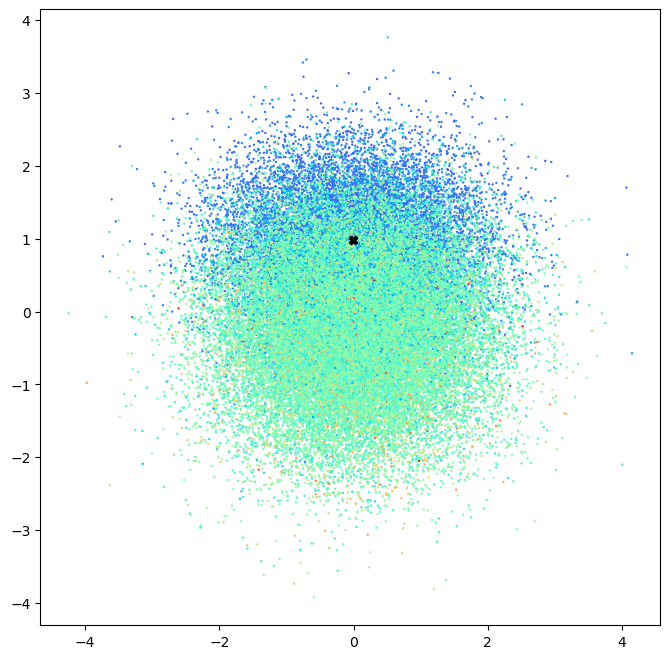

In [14]:
target = np.array([0,-2]).reshape(1, latent_dim)
bb_indices = traj.topology.select('backbone')
ca_indices = traj.topology.select('name CA')
emb, sample = plot_latent_space(latent_dim, enc, ds_all, conf, tr, z_mean, bb_indices, model=nn_model, exact=False)

In [15]:
rms_ref = md.load_pdb(conf)
rms_ref_bb  = rms_ref.atom_slice(bb_indices)
rms_ref_ca  = rms_ref.atom_slice(ca_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)
rmsd = md.rmsd(rms_tr, rms_ref)

In [16]:
p_indices = traj.topology.select("protein")
n_p = len(p_indices)

In [17]:
'''
s = dec.predict(sample)

coords_size = feat['coords'].shape[1]  # dimensione delle coordinate
angles_size = s.shape[1] - coords_size  # dimensione degli angoli

# Separa coordinate e angoli
s_coords = s[:, :coords_size]
s_angles = s[:, coords_size:]

# Inverti le trasformazioni separatamente
coords_orig = feat['scaler_coords'].inverse_transform(s_coords)
angles_orig = feat['scaler_angles'].inverse_transform(s_angles)

# Prendi solo le coordinate per la ricostruzione
coords_flat = coords_orig[0, :]                    
coords_p = coords_flat.reshape((n_p, 3))
mask_bb = np.isin(p_indices, bb_indices)
coords_bb = coords_p[mask_bb] 
coords_ca = coords_bb[1::4] 

new_traj = md.Trajectory(
    xyz=np.array([coords_bb]),     
    topology=rms_ref_bb.topology     
)
new_traj.save_pdb("./models/vae_reconstructed.pdb")
'''

'\ns = dec.predict(sample)\n\ncoords_size = feat[\'coords\'].shape[1]  # dimensione delle coordinate\nangles_size = s.shape[1] - coords_size  # dimensione degli angoli\n\n# Separa coordinate e angoli\ns_coords = s[:, :coords_size]\ns_angles = s[:, coords_size:]\n\n# Inverti le trasformazioni separatamente\ncoords_orig = feat[\'scaler_coords\'].inverse_transform(s_coords)\nangles_orig = feat[\'scaler_angles\'].inverse_transform(s_angles)\n\n# Prendi solo le coordinate per la ricostruzione\ncoords_flat = coords_orig[0, :]                    \ncoords_p = coords_flat.reshape((n_p, 3))\nmask_bb = np.isin(p_indices, bb_indices)\ncoords_bb = coords_p[mask_bb] \ncoords_ca = coords_bb[1::4] \n\nnew_traj = md.Trajectory(\n    xyz=np.array([coords_bb]),     \n    topology=rms_ref_bb.topology     \n)\nnew_traj.save_pdb("./models/vae_reconstructed.pdb")\n'

In [18]:
'''
view = nv.show_file('./models/vae_reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view
'''

"\nview = nv.show_file('./models/vae_reconstructed.pdb')\nview.clear_representations()\nview.add_line() \n#view.add_cartoon()\nview.center()\nview\n"

In [19]:
print(f'distances feat: {nD}, angles feat: {nA}')

distances feat: 40, angles feat: 76


In [20]:
s = dec.predict(sample)
orig = sample_x.numpy() 
recon = s[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


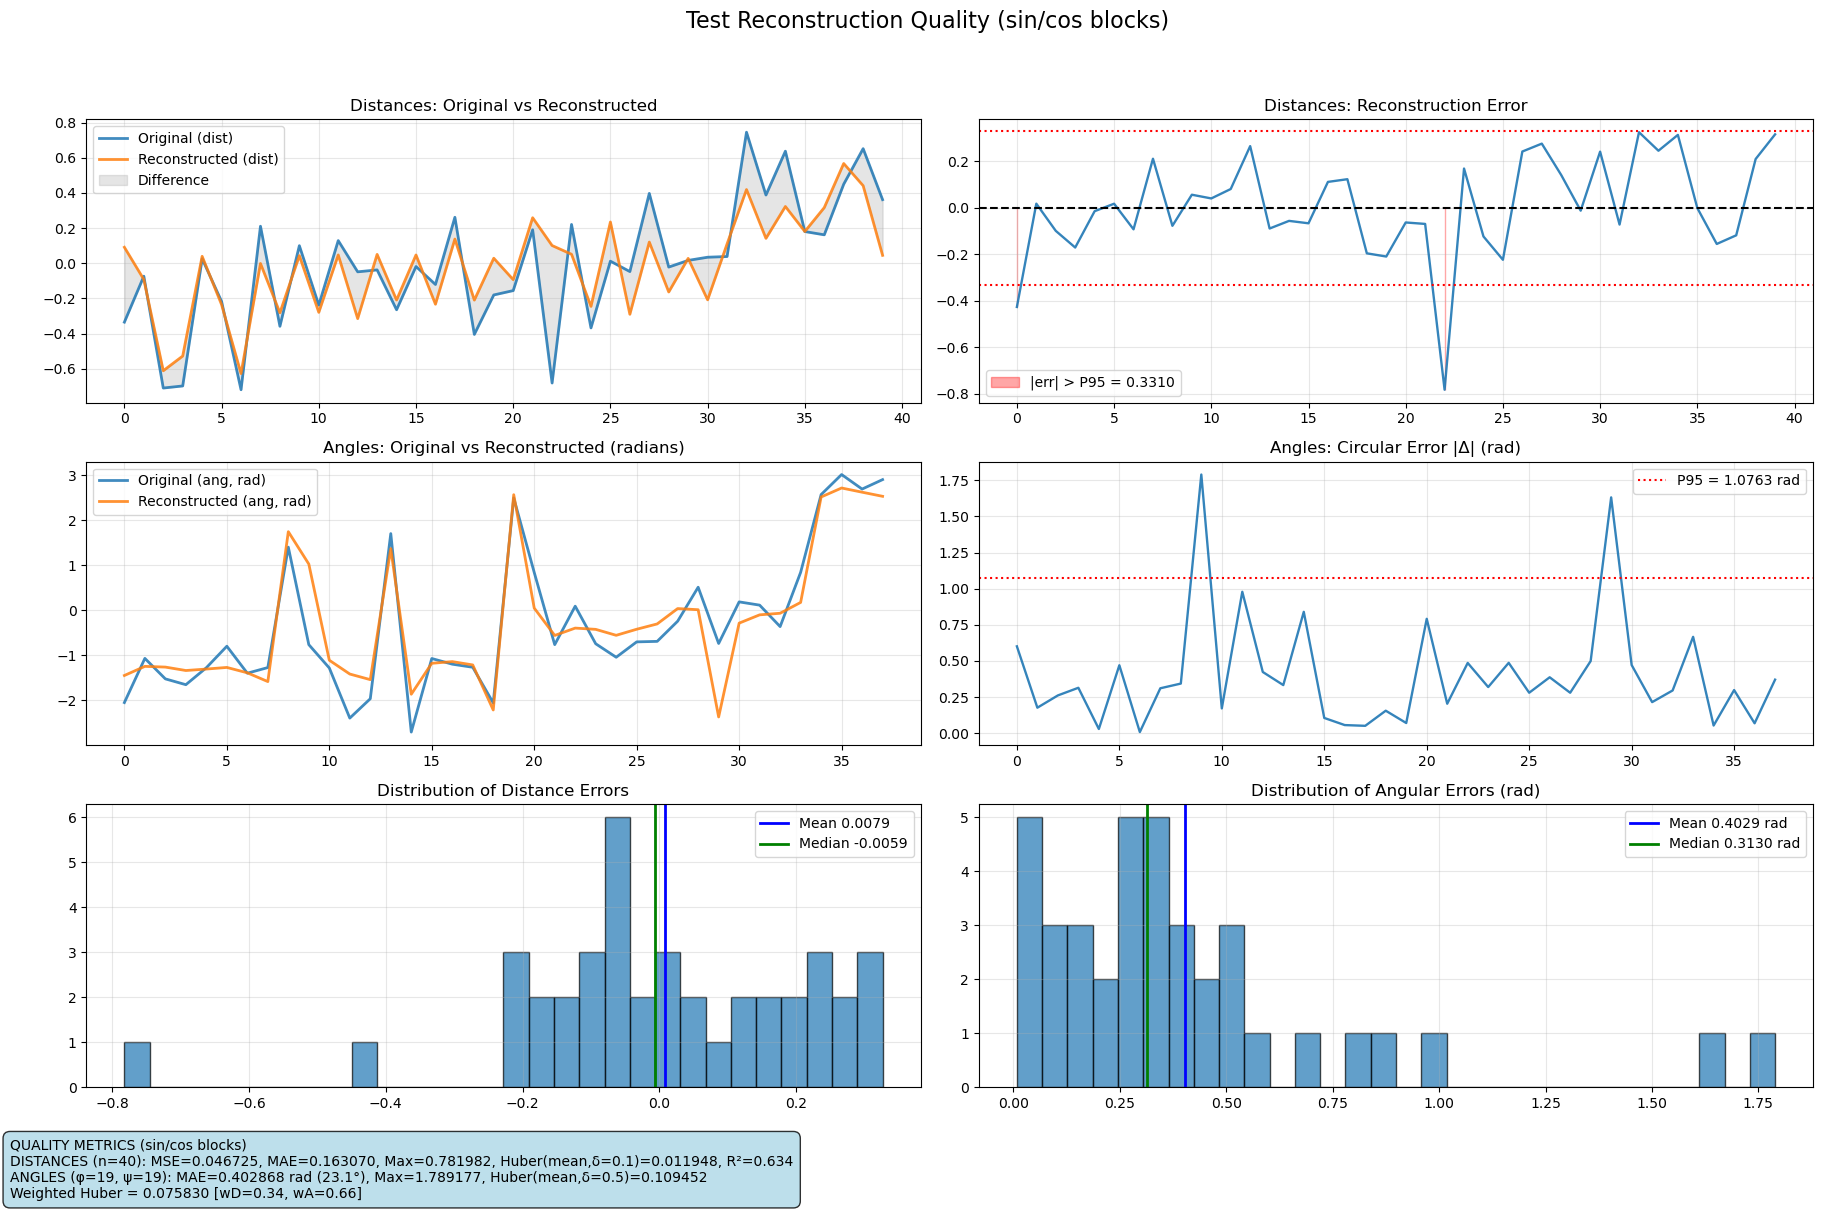

{'distances': {'mse': 0.04672548919916153, 'mae': 0.16306988894939423, 'max_abs_error': 0.7819822430610657, 'huber_mean': 0.011948063969612122, 'r_squared': 0.634419040889508, 'correlation': 0.7965042629449688}, 'angles': {'circ_mae_rad': 0.4028684198856354, 'circ_mae_deg': 23.082660158551235, 'max_circ_error_rad': 1.7891771793365479, 'huber_mean_circ': 0.10945155471563339}, 'weights': {'distances': 0.3448275862068966, 'angles': 0.6551724137931034}, 'overall_weighted_huber': 0.0758296613549364}


In [21]:
n_phi = 0 if feat['raw_angles']['phi'] is None else feat['raw_angles']['phi'].shape[1]
n_psi = 0 if feat['raw_angles']['psi'] is None else feat['raw_angles']['psi'].shape[1]

fig, metrics = analyze_reconstruction_with_sincos_blocks(
    orig, recon,
    nD=nD, n_phi=n_phi, n_psi=n_psi,
    deltaD=0.1, deltaA=0.5,
    title_prefix="Test "
)

plt.show()
print(metrics)

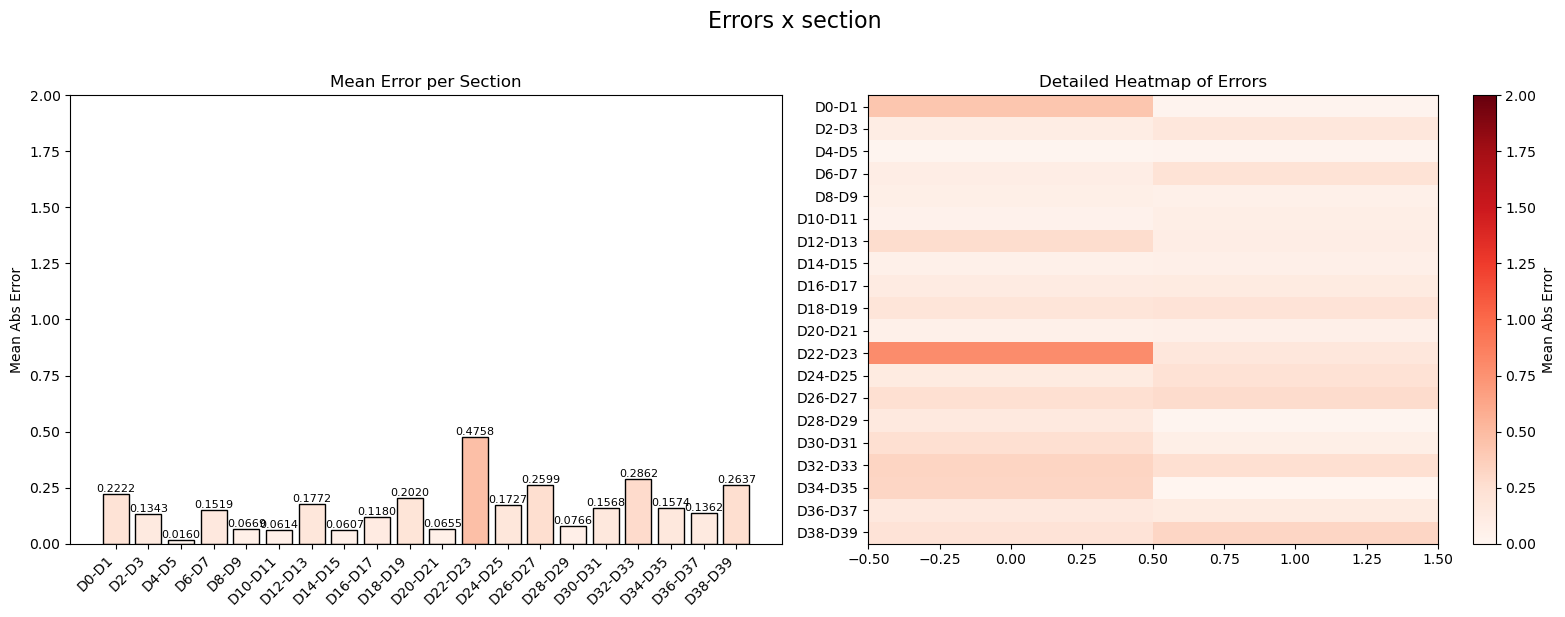

{'sections': [0.2222464233636856, 0.1342773735523224, 0.016040116548538208, 0.15185391902923584, 0.06687179207801819, 0.061357297003269196, 0.1772463321685791, 0.060691043734550476, 0.11802659928798676, 0.20200300216674805, 0.06546556949615479, 0.475831538438797, 0.17271625995635986, 0.25989773869514465, 0.07663483917713165, 0.1568375825881958, 0.2861610949039459, 0.15736861526966095, 0.1361769735813141, 0.2636936902999878], 'labels': ['D0-D1', 'D2-D3', 'D4-D5', 'D6-D7', 'D8-D9', 'D10-D11', 'D12-D13', 'D14-D15', 'D16-D17', 'D18-D19', 'D20-D21', 'D22-D23', 'D24-D25', 'D26-D27', 'D28-D29', 'D30-D31', 'D32-D33', 'D34-D35', 'D36-D37', 'D38-D39'], 'kind': 'distance'}


In [22]:
fig, sec_stats = plot_section_errors(
    orig, recon,
    nD=nD, n_phi=n_phi, n_psi=n_psi,
    n_sections=20,     
    kind="distance",  
    title="Errors x section"
)

plt.show()
print(sec_stats)

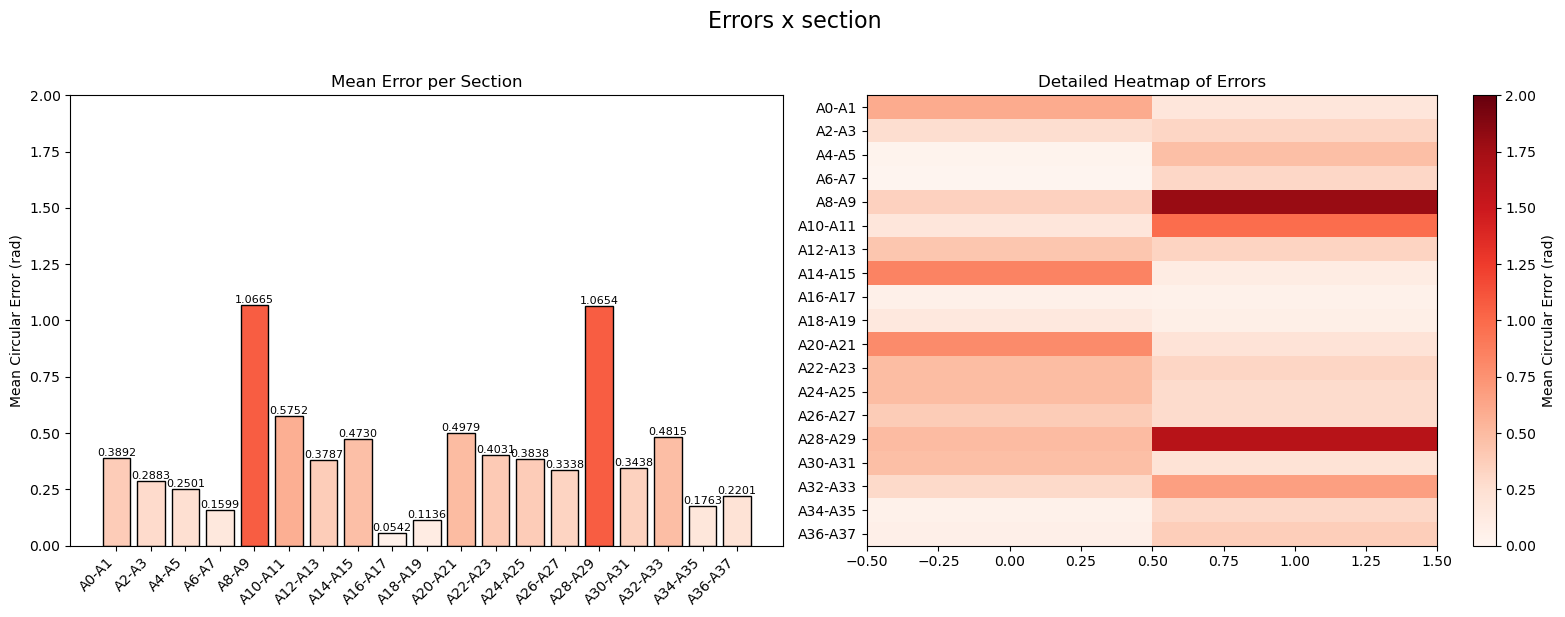

{'sections': [0.3892073631286621, 0.288276731967926, 0.25012174248695374, 0.1598692536354065, 1.0664860010147095, 0.5752208232879639, 0.3786560297012329, 0.4729658365249634, 0.05423802137374878, 0.11362874507904053, 0.4979409873485565, 0.40307164192199707, 0.38381099700927734, 0.33382946252822876, 1.0654094219207764, 0.3438490927219391, 0.4815477132797241, 0.1762535572052002, 0.22011637687683105], 'labels': ['A0-A1', 'A2-A3', 'A4-A5', 'A6-A7', 'A8-A9', 'A10-A11', 'A12-A13', 'A14-A15', 'A16-A17', 'A18-A19', 'A20-A21', 'A22-A23', 'A24-A25', 'A26-A27', 'A28-A29', 'A30-A31', 'A32-A33', 'A34-A35', 'A36-A37'], 'kind': 'angle'}


In [23]:
fig, sec_stats = plot_section_errors(
    orig, recon,
    nD=nD, n_phi=n_phi, n_psi=n_psi,
    n_sections=19,     
    kind="angle",  
    title="Errors x section"
)

plt.show()
print(sec_stats)